### Configuration

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr

from tqdm import tqdm
from pandas.arrays import IntervalArray

import mne
from mne.time_frequency import tfr_array_morlet
from scipy.stats import zscore

from utils__helpers_macro import hilbert_powerphase, hilbert_envelope
import utils__config

In [2]:
os.chdir(utils__config.working_directory)
os.getcwd()

'Z:\\Layton\\Sleep_083023'

### Parameters

In [3]:
fif_path = 'Cache/Subject05/Jul12/S05_Jul12_256hz.fif'
hypno_path = 'Cache/Subject05/Jul12/S05_Jul12_hypnogram.csv' 
spike_path = 'Cache/Subject05/Jul12/S05_spikes.csv'
legui_path = 'Cache/Subject05/S05_electrodes.csv'
bad_channel_path = 'Cache/Subject05/Jul12/S05_bad_channels.csv'
sw_channel_path = 'Cache/Subject05/Jul12/S05_event_rates.csv'

rayleigh_output_path = 'Cache/Subject05/Jul12/S05_STA_rayleigh.csv'
heatmap_output_path = 'Cache/Subject05/Jul12/S05_STA_heatmap.csv'
roseplot_output_path = 'Cache/Subject05/Jul12/S05_STA_roseplot.csv'

sampling_freq = 256
n_jobs = -2

### Load Data

In [4]:
raw = mne.io.read_raw_fif(fif_path, preload = True, verbose = None)

# Select only macroelectrodes
raw.pick_types(seeg = True, ecog = True)

# Remove rejected channels
bad_channels = pd.read_csv(bad_channel_path)
bad_channels = bad_channels[bad_channels['channel'].isin(raw.ch_names)]
raw.drop_channels(ch_names = bad_channels['channel'].astype('string'))

# Select only channels with < 3 SW/minute in NREM sleep
sw_rates = pd.read_csv(sw_channel_path)
sw_rates = sw_rates.loc[sw_rates.sw >= 3, 'Channel'].tolist()
raw.pick_channels(sw_rates)

Opening raw data file Cache/Subject05/Jul12/S05_Jul12_256hz.fif...


C:\Users\lal85\AppData\Local\Temp\3\ipykernel_34028\631887471.py:1: RuntimeWarning: This filename (Cache/Subject05/Jul12/S05_Jul12_256hz.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_path, preload = True, verbose = None)


    Range : 0 ... 7249663 =      0.000 ... 28318.996 secs
Ready.
Opening raw data file Z:\Layton\Sleep_083023\Cache\Subject05\Jul12\S05_Jul12_256hz-1.fif...
    Range : 7249664 ... 9720319 =  28319.000 ... 37969.996 secs
Ready.
Reading 0 ... 9720319  =      0.000 ... 37969.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\lal85\AppData\Local\Temp\3\ipykernel_34028\631887471.py:14: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw.pick_channels(sw_rates)


<Raw | S05_Jul12_256hz.fif, 27 x 9720320 (37970.0 s), ~1.96 GB, data loaded>

### Extract Slow Wave Phase and Envelope (0.3 - 1.5 Hz)

In [5]:
# Extract Power and Phase
delta = raw.copy()
delta = hilbert_powerphase(data = delta, lower = 0.3, upper = 1.5, njobs = n_jobs)
delta = delta[['time', 'channel', 'power', 'phase']]

# Extract Envelope
sw_env = raw.copy()
sw_env = hilbert_envelope(sw_env, lower = 0.3, upper = 1.5, njobs = n_jobs)
sw_env = sw_env[['time', 'channel', 'envelope']]

# Merge Power/Phase and Envelope
delta = delta.merge(sw_env, on = ['time', 'channel'])

# Calculate z-score of power and envelope
delta['log_power'] = 10 * np.log10(delta['power'])
delta['zlog_power'] = delta.groupby(['channel'])['log_power'].transform(zscore)
delta['z_envelope'] = delta.groupby(['channel'])['envelope'].transform(zscore)

delta = delta[['time', 'channel', 'phase', 'zlog_power', 'z_envelope']]

# Load hypnogram
hypno = pd.read_csv(hypno_path, header = None)
hypno = hypno.reset_index()
hypno.columns = ['sample', 'stage']
hypno['time'] = hypno['sample'] / sampling_freq

# Merge with hypnogram
delta = pd.merge_asof(delta.sort_values('time'), hypno.sort_values('time'), 
                      left_on = 'time', right_on = 'time', direction = 'nearest')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 1.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.50 Hz)
- Filter length: 2817 samples (11.004 s)



[Parallel(n_jobs=-2)]: Using backend LokyBackend with 31 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 out of  27 | elapsed:    4.6s remaining:   37.5s
[Parallel(n_jobs=-2)]: Done   9 out of  27 | elapsed:    5.8s remaining:   11.8s
[Parallel(n_jobs=-2)]: Done  15 out of  27 | elapsed:    6.4s remaining:    5.1s
[Parallel(n_jobs=-2)]: Done  21 out of  27 | elapsed:    7.0s remaining:    1.9s
[Parallel(n_jobs=-2)]: Done  27 out of  27 | elapsed:    7.4s finished


Converting "channel" to "category"...
Converting "ch_type" to "category"...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 1.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.50 Hz)
- Filter length: 2817 samples (11.004 s)



[Parallel(n_jobs=-2)]: Using backend LokyBackend with 31 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 out of  27 | elapsed:    1.3s remaining:   10.8s
[Parallel(n_jobs=-2)]: Done   9 out of  27 | elapsed:    2.5s remaining:    5.0s
[Parallel(n_jobs=-2)]: Done  15 out of  27 | elapsed:    4.0s remaining:    3.2s
[Parallel(n_jobs=-2)]: Done  21 out of  27 | elapsed:    4.6s remaining:    1.3s
[Parallel(n_jobs=-2)]: Done  27 out of  27 | elapsed:    5.0s finished


Converting "channel" to "category"...
Converting "ch_type" to "category"...


C:\Users\lal85\AppData\Local\Temp\3\ipykernel_34028\4168691617.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delta['zlog_power'] = delta.groupby(['channel'])['log_power'].transform(zscore)
C:\Users\lal85\AppData\Local\Temp\3\ipykernel_34028\4168691617.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delta['z_envelope'] = delta.groupby(['channel'])['envelope'].transform(zscore)


### Intersect Spike Times with Envelope/Phase and Sleep Stage

In [6]:
# Load Spike data
spikes = pd.read_csv(spike_path)
spikes = spikes[['unit_id', 'seconds', 'unit_laterality', 'unit_region']]

data = pd.DataFrame()

for chan in tqdm(delta.channel.unique()):

    # Subset the phase-envelope dataset
    sw_data = delta[delta.channel == chan].copy(deep = True)

    # For every spike, find the nearest 
    # sample in the phase-envelope dataset...
    data_temp = pd.merge_asof(spikes.sort_values('seconds'), sw_data.sort_values('time'), 
                              left_on = 'seconds', right_on = 'time', direction = 'nearest')

    data_temp.drop(columns = ['time', 'sample'], inplace = True)

    # Concatenate into final dataset
    data = pd.concat((data, data_temp))

100%|██████████| 27/27 [01:07<00:00,  2.50s/it]


In [7]:
# Filter dataframe based on sleep stage values
data = data[data['stage'].isin([2, 3])]

# Merge with channel dictionary
legui = pd.read_csv(legui_path)
legui = legui[['elec_label', 'roi_3', 'roi_4', 'lobe_1']]
data = data.merge(legui, left_on='channel', right_on='elec_label').drop(columns='elec_label')

### Perform Rayleigh Test

In [8]:
from astropy.stats import rayleightest as rayleigh

# Process the data
results = []

for (unit, channel), group in data.groupby(['unit_id', 'channel']):
    phases = group['phase'].to_numpy()
    p_value = rayleigh(phases)
    
    # Extract metadata from the first row of the group
    meta_data = group.iloc[0][['unit_laterality', 'unit_region', 'roi_3', 'roi_4', 'lobe_1']].tolist()
    
    results.append([unit, channel, p_value] + meta_data)

# Convert results to a DataFrame
result_df = pd.DataFrame(results, columns=['unit_id', 'channel', 'p_value', 'unit_laterality', 'unit_region', 'roi_3', 'roi_4', 'lobe_1'])
result_df.to_csv(rayleigh_output_path, index = False)

C:\Users\lal85\AppData\Local\Temp\3\ipykernel_34028\1179657474.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_df = pivot_df.applymap(lambda x: 1 if x < 0.01 else 0)


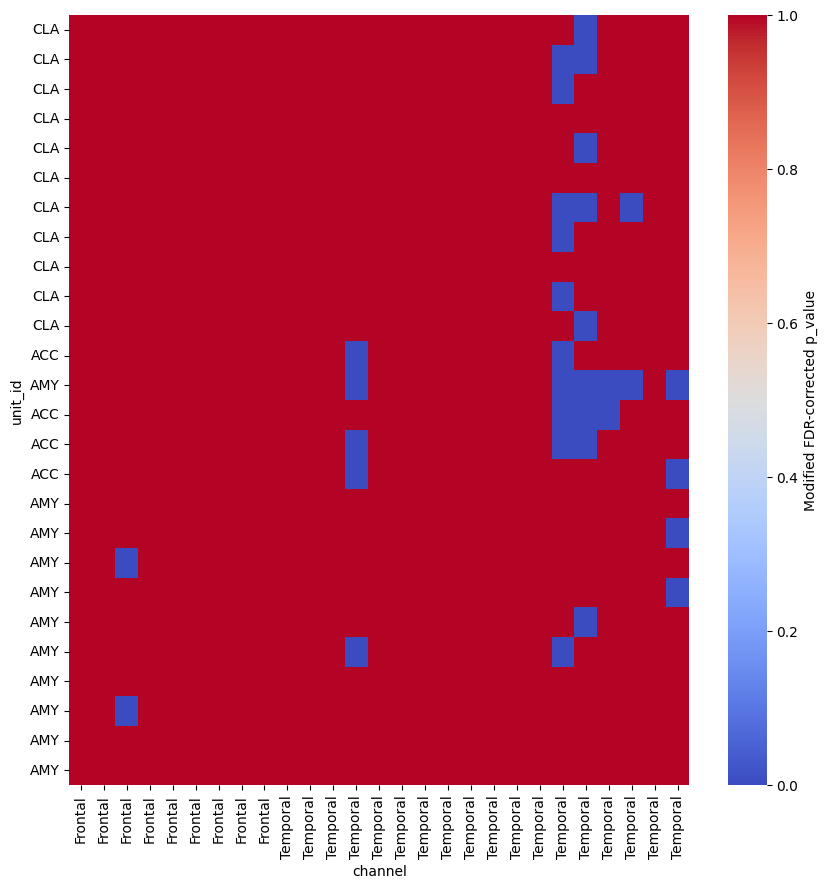

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Correct p_values for FDR using Benjamini-Hochberg procedure
result_df['p_value_corrected'] = sm.stats.multipletests(result_df['p_value'], method='fdr_bh')[1]

# Pivot the dataframe using corrected p-values
pivot_df = result_df.pivot(index='unit_id', columns='channel', values='p_value_corrected')

# Modify corrected p_value values
pivot_df = pivot_df.applymap(lambda x: 1 if x < 0.01 else 0)

# Replace row labels
row_labels = result_df.set_index('unit_id')['unit_region'].to_dict()
pivot_df.index = pivot_df.index.to_series().map(row_labels)

# Get a list of channels ordered by lobe_1 values
ordered_channels = result_df.sort_values('lobe_1')['channel'].unique()

# Reorder the columns of the pivoted dataframe
pivot_df = pivot_df[ordered_channels]

# Replace column labels
column_labels = result_df.drop_duplicates('channel').set_index('channel')['lobe_1'].to_dict()
pivot_df.columns = pivot_df.columns.to_series().map(column_labels)

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(pivot_df, cmap='coolwarm', cbar_kws={'label': 'Modified FDR-corrected p_value'})
plt.show()

### Format for Heatmap

In [10]:
# Bin phase values into discrete bins
n_bins = 36  # adjust as needed
data['phase_bin'] = pd.cut(data['phase'], bins=n_bins, labels=False)

# Compute MI for each unit-channel pair
def compute_MI(group):
    R = group['phase_bin'].value_counts().max()  # maximal firing rate
    R_exp = len(group) / n_bins  # mean firing rate across all bins
    MI = (R - R_exp) / (R + R_exp)
    return MI

MI_values = data.groupby(['unit_id', 'channel']).apply(compute_MI).reset_index()
MI_values.columns = ['unit_id', 'channel', 'MI']

# Create a mapping of unit_id to unit_region
unit_to_region = data[['unit_id', 'unit_laterality', 'unit_region']].drop_duplicates()
channel_to_roi = data[['channel', 'roi_4', 'lobe_1']].drop_duplicates()

# Merge the unit_region onto MI_values
MI_values = MI_values.merge(unit_to_region, on='unit_id')
MI_values = MI_values.merge(channel_to_roi, on='channel')

# Save heatmap data to CSV
MI_values.to_csv(heatmap_output_path, index=False)
MI_values

,unit_id,channel,MI,unit_laterality,unit_region,roi_4,lobe_1
0,S05_Ch193_neg_Unit1,LAC7,0.089596,left,CLA,L MFG,Frontal
1,S05_Ch193_neg_Unit2,LAC7,0.101756,left,CLA,L MFG,Frontal
2,S05_Ch194_neg_Unit2,LAC7,0.100843,left,CLA,L MFG,Frontal
3,S05_Ch195_neg_Unit5,LAC7,0.104111,left,CLA,L MFG,Frontal
4,S05_Ch196_neg_Unit2,LAC7,0.101447,left,CLA,L MFG,Frontal
...,...,...,...,...,...,...,...
697,S05_Ch237_neg_Unit2,RPHC8,0.059939,right,AMY,R MTG,Temporal
698,S05_Ch238_neg_Unit2,RPHC8,0.067201,right,AMY,R MTG,Temporal
699,S05_Ch238_neg_Unit3,RPHC8,0.091990,right,AMY,R MTG,Temporal
700,S05_Ch239_neg_Unit2,RPHC8,0.066798,right,AMY,R MTG,Temporal


### Format for Rose Plots

In [11]:
top_num = 10

# Identify the top unit_id-channel pairs for each unit_region by mean MI
top_phase_data_list = []
unique_regions = data['unit_region'].unique()

for region in unique_regions:
    top_MI = MI_values[MI_values['unit_region'] == region].groupby(['unit_id', 'channel']).MI.mean().nlargest(top_num)
    top_pairs = top_MI.index.tolist()

    for unit, ch in top_pairs:
        phase_data_subset = data[(data['unit_id'] == unit) & (data['channel'] == ch)][['unit_id', 'unit_laterality', 'unit_region', 'channel', 'roi_4', 'lobe_1', 'phase']]
        #phase_data_subset['unit_region'] = region
        top_phase_data_list.append(phase_data_subset)

# Combine all top phase data subsets and save to CSV
top_phase_data = pd.concat(top_phase_data_list, axis=0)
top_phase_data.to_csv(roseplot_output_path, index=False)
top_phase_data

,unit_id,unit_laterality,unit_region,channel,roi_4,lobe_1,phase
16418664,S05_Ch234_neg_Unit2,right,AMY,RAM1,R AMY,Temporal,-2.883658
16418669,S05_Ch234_neg_Unit2,right,AMY,RAM1,R AMY,Temporal,-2.675005
16418684,S05_Ch234_neg_Unit2,right,AMY,RAM1,R AMY,Temporal,-1.405228
16418706,S05_Ch234_neg_Unit2,right,AMY,RAM1,R AMY,Temporal,-2.996967
16418728,S05_Ch234_neg_Unit2,right,AMY,RAM1,R AMY,Temporal,2.662693
...,...,...,...,...,...,...,...
19701977,S05_Ch225_neg_Unit4,right,ACC,RAC6,R MFG,Frontal,0.486685
19701982,S05_Ch225_neg_Unit4,right,ACC,RAC6,R MFG,Frontal,0.548409
19702028,S05_Ch225_neg_Unit4,right,ACC,RAC6,R MFG,Frontal,1.529330
19702183,S05_Ch225_neg_Unit4,right,ACC,RAC6,R MFG,Frontal,-2.632913
